In [82]:
import pandas as pd
import statsmodels
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import pmdarima
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
from math import sqrt
import statsmodels.api as sm
from pandas.tseries.offsets import DateOffset

In [39]:
df_sales = pd.read_csv('Discount Mart Monthly Sales.csv')
print(df_sales.info())
print(df_sales.head(3))
print(df_sales.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        105 non-null    object
 1   Total Sales  105 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ KB
None
     Month  Total Sales
0  1964-01         2815
1  1964-02         2672
2  1964-03         2755
Month          0
Total Sales    0
dtype: int64


In [40]:
df_sales['Month']=pd.to_datetime(df_sales['Month'])

In [41]:
df_sales.set_index('Month',inplace=True)
df_sales['Total Sales'] = df_sales['Total Sales'].astype(float)

In [42]:
print(df_sales.head(), "\n\n")
print(df_sales.describe())

            Total Sales
Month                  
1964-01-01       2815.0
1964-02-01       2672.0
1964-03-01       2755.0
1964-04-01       2721.0
1964-05-01       2946.0 


        Total Sales
count    105.000000
mean    4761.152381
std     2553.502601
min     1413.000000
25%     3113.000000
50%     4217.000000
75%     5221.000000
max    13916.000000


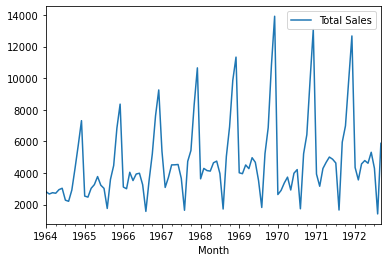

In [43]:
df_sales.plot()

#### Looking this graph,we can say this data is seasonal

#### (seasonal is all about suppose in each yr in christmas sales goes up) and then down. We need to check whether data is stationary or not. We can Check that by ADF Test



In [44]:
#adfuller gives 5 values ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
#most imp is p-value
#this is almost similar to Hypothesis testing,whereas Null hypo which says Data is not Stationery
#whereas Alternate hypo says data is stationery

###if Pvalue<0.05 ,we reject Null hypo ie alternate hypo is true,ie data is stationery


def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [45]:
adfuller_test(df_sales['Total Sales'])

ADF Test Statistic : -1.8335930563276195
p-value : 0.3639157716602467
#Lags Used : 11
Number of Observations Used : 93
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


### We can see from above that our data is stationary and we can remove the stationarity of the data using a method called as Differencing.

For our differencing the time number of observations we arevtaking is 12 because that is the the one whole year

## Differencing

In [46]:
df_sales['Seasonal First Difference'] = df_sales['Total Sales'] - df_sales['Total Sales'].shift(12)

In [47]:
## Again test dickey fuller test on df['Sales First Difference']
adfuller_test(df_sales['Seasonal First Difference'].dropna())

ADF Test Statistic : -7.626619157213166
p-value : 2.0605796968136632e-11
#Lags Used : 0
Number of Observations Used : 92
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


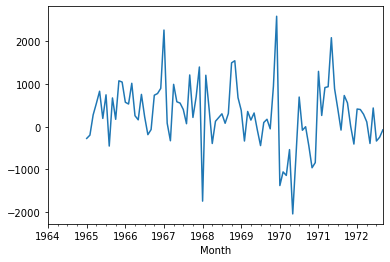

In [48]:
#Now our p-value is less than 0.05 which basically says we are rejecting null hypo and accepting alternate hypo ie data is stationery
#if p-value is almost 0,then we have a wonderful stationery graph

df_sales['Seasonal First Difference'].plot()

# Automating the process of selecting the parameters for aur ARIMA model


In [69]:
stepwise_fit = auto_arima(df_sales['Total Sales'], trace=True,
suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1937.732, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1938.874, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1937.889, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1935.750, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.532 seconds


#### We saw from the above plot that the best params for the ARIMA model are (0,1,0).

We will put the above parameters in our ARIMA model and will predict

##### We will be using SARIMA model because our data has seasonality in it.

In [61]:
model=sm.tsa.statespace.SARIMAX(df_sales['Total Sales'],order=(1, 1, 1),seasonal_order=(1,1,1,12))
results=model.fit()

In [63]:
model=sm.tsa.statespace.SARIMAX(df_sales['Total Sales'],order=(1, 1, 1),seasonal_order=(0,1,0,12))
results=model.fit()

In [79]:
#predicting from index 90 to 103
print(df_sales.shape)
df_sales['forecast']=results.predict(start=90,end=104,dynamic=True)

(105, 3)


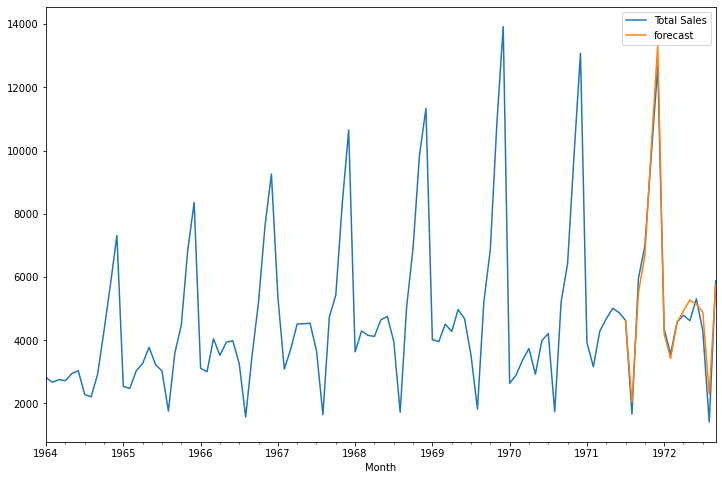

In [80]:

df_sales[['Total Sales','forecast']].plot(figsize=(12,8))

### Prediciting for the future months

In [88]:
future_dates=[df_sales.index[-1]+ DateOffset(months=x)for x in range(0,24)]
future_dates

[Timestamp('1972-09-01 00:00:00'),
 Timestamp('1972-10-01 00:00:00'),
 Timestamp('1972-11-01 00:00:00'),
 Timestamp('1972-12-01 00:00:00'),
 Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-02-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-05-01 00:00:00'),
 Timestamp('1973-06-01 00:00:00'),
 Timestamp('1973-07-01 00:00:00'),
 Timestamp('1973-08-01 00:00:00'),
 Timestamp('1973-09-01 00:00:00'),
 Timestamp('1973-10-01 00:00:00'),
 Timestamp('1973-11-01 00:00:00'),
 Timestamp('1973-12-01 00:00:00'),
 Timestamp('1974-01-01 00:00:00'),
 Timestamp('1974-02-01 00:00:00'),
 Timestamp('1974-03-01 00:00:00'),
 Timestamp('1974-04-01 00:00:00'),
 Timestamp('1974-05-01 00:00:00'),
 Timestamp('1974-06-01 00:00:00'),
 Timestamp('1974-07-01 00:00:00'),
 Timestamp('1974-08-01 00:00:00')]

In [91]:
future_dataset_df=pd.DataFrame(index=future_dates[1:],columns=df_sales.columns)

In [92]:
future_dataset_df.tail()

,Total Sales,Seasonal First Difference,forecast
1974-04-01,NaN,NaN,NaN
1974-05-01,NaN,NaN,NaN
1974-06-01,NaN,NaN,NaN
1974-07-01,NaN,NaN,NaN
1974-08-01,NaN,NaN,NaN


In [97]:
future_df=pd.concat([df_sales,future_datset_df])

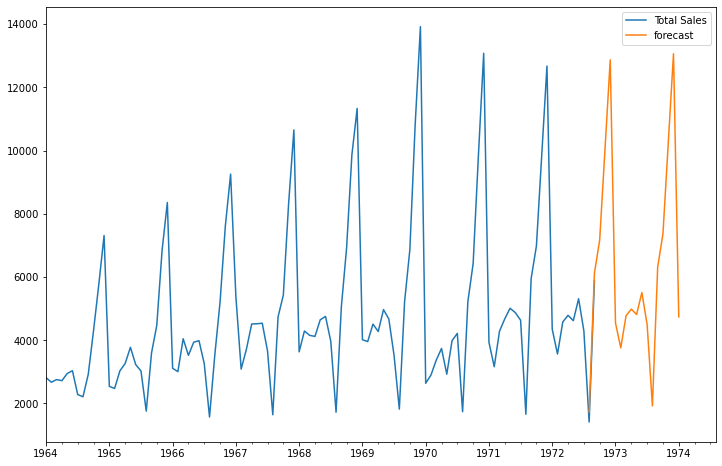

In [99]:
# Predicting for the future Months

future_df['forecast'] = results.predict(start = 103, end = 120, dynamic= True)  
future_df[['Total Sales', 'forecast']].plot(figsize=(12, 8)) 